# Implementing Perceptron Algorithm from Scratch

In this notebook, I implement Logistic Regression using Perceptron unit from scratch and I further add a few extra things like:
* Mini-Batch Training
* L2 Regularization

The logistic regression model is trained on the Banana dataset obtained from kaggle: https://www.kaggle.com/datasets/l3llff/banana

This code is almost the same as the Logistic Regression Implementation on Banana Quality Dataset, only difference is the use of Perceptron activation instead of the Sigmoid activation

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from scipy.io import loadmat
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv('banana_quality.csv')

print(data.shape)

(8000, 8)


In [ ]:
data.head()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,-1.924968,0.468078,3.077832,-1.472177,0.294799,2.435570,0.271290,Good
1,-2.409751,0.486870,0.346921,-2.495099,-0.892213,2.067549,0.307325,Good
2,-0.357607,1.483176,1.568452,-2.645145,-0.647267,3.090643,1.427322,Good
3,-0.868524,1.566201,1.889605,-1.273761,-1.006278,1.873001,0.477862,Good
4,0.651825,1.319199,-0.022459,-1.209709,-1.430692,1.078345,2.812442,Good


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         8000 non-null   float64
 1   Weight       8000 non-null   float64
 2   Sweetness    8000 non-null   float64
 3   Softness     8000 non-null   float64
 4   HarvestTime  8000 non-null   float64
 5   Ripeness     8000 non-null   float64
 6   Acidity      8000 non-null   float64
 7   Quality      8000 non-null   object 
dtypes: float64(7), object(1)
memory usage: 500.1+ KB


In [ ]:
data.shape

(8000, 8)

In [ ]:
data.loc[5]

Size          -2.807722
Weight         1.138136
Sweetness      3.447627
Softness      -1.713302
HarvestTime   -2.220912
Ripeness        2.07941
Acidity        2.281203
Quality            Good
Name: 5, dtype: object

In [ ]:
data['Sweetness'].max()

7.539374

In [ ]:
data.describe()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,-0.747802,-0.761019,-0.770224,-0.014441,-0.751288,0.781098,0.008725
std,2.136023,2.015934,1.948455,2.065216,1.996661,2.114289,2.293467
min,-7.998074,-8.283002,-6.434022,-6.959320,-7.570008,-7.423155,-8.226977
25%,-2.277651,-2.223574,-2.107329,-1.590458,-2.120659,-0.574226,-1.629450
50%,-0.897514,-0.868659,-1.020673,0.202644,-0.934192,0.964952,0.098735
75%,0.654216,0.775491,0.311048,1.547120,0.507326,2.261650,1.682063
max,7.970800,5.679692,7.539374,8.241555,6.293280,7.249034,7.411633


In [ ]:
X = np.array(data)[:,:-1].astype(np.float64)

Y = np.array(data['Quality'] == 'Good').astype('int')

In [ ]:
print(X.shape, X[1])

print(Y.shape)

(8000, 7) [-2.4097514   0.48686993  0.34692144 -2.4950993  -0.8922133   2.0675488
  0.30732512]
(8000,)


In [ ]:
arb = np.random.randint(0,8000)

print(arb)
print(data.iloc[arb])
print(Y[arb])

5561
Size           2.874354
Weight          0.23028
Sweetness     -2.674152
Softness       3.740902
HarvestTime    3.485324
Ripeness       2.002497
Acidity          2.1403
Quality            Good
Name: 5561, dtype: object
1


In [ ]:
# We start our data preprocessing and actual ML coding here

m = X.shape[0]
n = X.shape[1]

print(f"Training examples: {m}, Features: {n}")

Training examples: 8000, Features: 7


In [ ]:
# creating a normalization function
# Need some clarification on this. Remember to ask
def normalize(data):
    mean = np.mean(data, axis=0, keepdims=True)
    # print(mean)
    std = np.std(data, axis=0, keepdims=True)
    # print(std)
    data_normalized = (data - mean)/std
    return data_normalized


In [ ]:
X_norm = normalize(X)

In [ ]:
print(X[10], X_norm[10], Y[10])

[-1.5878931   1.4466584   0.13883868 -2.8589776  -1.7612225   2.4337273
  1.7631273 ] [-0.39332156  1.09518243  0.46658489 -1.37744168 -0.50584322  0.78169633
  0.76500432] 1


In [ ]:
a = [[1, 2, 3, 4, 5, 6], [-1, -2, -3, -4, -5, -6]]

np.mean(a, axis=0)

array([0., 0., 0., 0., 0., 0.])

In [ ]:
# Concatenating X with a column of ones
def concatenator(X):
    m = X.shape[0]
    arb = np.hstack((np.ones([m,1]),X))
    print(f"The data now has a column of ones in front. It went from dimensions {X.shape} to {arb.shape}")
    return arb

In [ ]:
# Split to train and test

X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.20, random_state=42)
Y_train = Y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)
print("The shape of the training set feature matrix is:", X_train.shape)
print("The shape of the training label vector is:", Y_train.shape)
print("The shape of the test set feature matrix is:", X_test.shape)
print("The shape of the test label vector is:", Y_test.shape)

print(np.sum((Y_train==0).astype(int)))
print(np.sum((Y_test==0).astype(int)))

The shape of the training set feature matrix is: (6400, 7)
The shape of the training label vector is: (6400, 1)
The shape of the test set feature matrix is: (1600, 7)
The shape of the test label vector is: (1600, 1)
3213
781


In [ ]:
X_train_n = concatenator(X_train)
X_test_n = concatenator(X_test)

print(X_train_n.shape)
print(X_test_n.shape)


The data now has a column of ones in front. It went from dimensions (6400, 7) to (6400, 8)
The data now has a column of ones in front. It went from dimensions (1600, 7) to (1600, 8)
(6400, 8)
(1600, 8)


In [ ]:
a = np.array([1, -1, 2, -3])

print((a > 0).astype('int'))

[1 0 1 0]


In [ ]:
# Gradient initializer
def initializer(n):
    theta = np.zeros((n,1))
    return theta

# Implementation of sigmoid function
def step(z):
    return (z > 0).astype('int')

def sig(z):
    return 1/(1 + np.exp(-z))

# Implementation of hypothesis
def hypothesis(X, theta):
    h = np.dot(X, theta)
    return step(h)

# Implementation of cost function
def cost(X, y, theta, lam):
    m = X.shape[0]
    h = hypothesis(X, theta)
    arb = (1 - y * h) > 0
    J = np.sum(arb) / m + (lam / (2*m)) * np.dot(theta.T, theta)
    J = J.item()
    return J

# Gradient Calculations
def grad(X, y, theta, lam):
    m = X.shape[0]
    n = X.shape[1]
    h = hypothesis(X, theta)
    dtheta = np.dot(X.T, (h-y)) / m

    arb = np.zeros((n,1))
    arb[1:] = theta[1:]
    dtheta = dtheta + (lam / m) * arb
    return dtheta

In [ ]:
# Create prediction function

def predict(X, theta):
    Yhat_prob = step(np.matmul(X, theta))
    Yhat = np.round(Yhat_prob).astype(int)
    return Yhat, Yhat_prob

# Create prediction function, this is for

def predictor(X, theta):
    Yhat_prob = step(theta[0] + np.dot(X, theta[1:]))
    Yhat = np.round(Yhat_prob).astype(int)
    return Yhat, Yhat_prob

In [ ]:
# Creating the gradient descent optimizer function

def gradient_descent(X, Y, X_test, Y_test, theta, alpha, epoch, batch_size, lam):
    i=0
    RMSE = 1
    m = X.shape[0]
    blocks = np.ceil(m / batch_size).astype('int')

    cost_history=[]
    test_acc_history = []
    train_acc_history = []

    J = cost(X, Y, theta, lam)

    cost_history.append(J)

    Yhat, _ = predict(X, theta)
    train_accuracy = accuracy_score(Yhat, Y_train)
    train_acc_history.append(train_accuracy)

    Yhat, _ = predict(X_test, theta)
    test_accuracy = accuracy_score(Yhat, Y_test)
    test_acc_history.append(test_accuracy)

    # while (i<max_iter):
    #     print(f"Iteration count: {i} / {max_iter}", end = '\r')
    #     J = cost(X, Y, theta, lam)
    #     dtheta = grad(X, Y, theta, lam)
    #     theta = theta - alpha * dtheta

    #     cost_history.append(J)

    #     Yhat, _ = predict(X, theta)
    #     train_accuracy = accuracy_score(Yhat, Y_train)
    #     train_acc_history.append(train_accuracy)

    #     Yhat, _ = predict(X_test, theta)
    #     test_accuracy = accuracy_score(Yhat, Y_test)
    #     test_acc_history.append(test_accuracy)

    for i in range(epoch):
        print(f"Epoch number: {i} / {epoch}")

        print(f"Cost: {J}, Train accuracy: {train_accuracy * 100} %, Test accuracy: {test_accuracy * 100} %")



        for k in range(blocks):
            # print(f"Block count: {k*batch_size} / {m}")

            if (k+1) == blocks:
                X_curr = X[(k*batch_size):,:]
                Y_curr = Y[(k*batch_size):,:]
            else:
                X_curr = X[(k*batch_size):((k+1)*batch_size),:]
                Y_curr = Y[(k*batch_size):((k+1)*batch_size),:]

            J = cost(X_curr, Y_curr, theta, lam)
            dtheta = grad(X_curr, Y_curr, theta, lam)
            theta = theta - alpha * dtheta

            cost_history.append(J)

            Yhat, _ = predict(X, theta)
            train_accuracy = accuracy_score(Yhat, Y_train)
            train_acc_history.append(train_accuracy)

            Yhat, _ = predict(X_test, theta)
            test_accuracy = accuracy_score(Yhat, Y_test)
            test_acc_history.append(test_accuracy)


    return cost_history, train_acc_history, test_acc_history, theta, i

In [ ]:
def LogRegModel(X_train, Y_train, X_test, Y_test, alpha, epoch, batch_size, lam):

    n = X_train.shape[1]
    theta = initializer(n)
    cost_history, train_acc_history, test_acc_history, theta, i = gradient_descent(X_train, Y_train, X_test, Y_test, theta, alpha, epoch, batch_size, lam)
    Yhat_train, _ = predict(X_train, theta)
    Yhat, _ = predict(X_test, theta)

    train_acc = accuracy_score(Y_train, Yhat_train)
    test_acc = accuracy_score(Y_test, Yhat)
    conf_matrix = confusion_matrix(Y_test, Yhat, normalize = None)

    model = {'weights': theta,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'confusion_matrix': conf_matrix,
            'cost_history': cost_history,
             'train_history': train_acc_history,
             'test_history': test_acc_history}
    return model

Epoch number: 0 / 1000
Cost: 1.0, Train accuracy: 50.20312500000001 %, Test accuracy: 48.8125 %
Epoch number: 1 / 1000
Cost: 1.0, Train accuracy: 65.640625 %, Test accuracy: 67.1875 %
Epoch number: 2 / 1000
Cost: 0.503125, Train accuracy: 84.75 %, Test accuracy: 85.6875 %
Epoch number: 3 / 1000
Cost: 0.53546875, Train accuracy: 86.765625 %, Test accuracy: 86.9375 %
Epoch number: 4 / 1000
Cost: 0.54859375, Train accuracy: 87.25 %, Test accuracy: 87.5625 %
Epoch number: 5 / 1000
Cost: 0.5565625, Train accuracy: 87.390625 %, Test accuracy: 87.8125 %
Epoch number: 6 / 1000
Cost: 0.56078125, Train accuracy: 87.671875 %, Test accuracy: 87.625 %
Epoch number: 7 / 1000
Cost: 0.55984375, Train accuracy: 87.59375 %, Test accuracy: 87.375 %
Epoch number: 8 / 1000
Cost: 0.56234375, Train accuracy: 87.75 %, Test accuracy: 87.6875 %
Epoch number: 9 / 1000
Cost: 0.56015625, Train accuracy: 87.484375 %, Test accuracy: 87.375 %
Epoch number: 10 / 1000
Cost: 0.5665625, Train accuracy: 87.78125 %, Test a

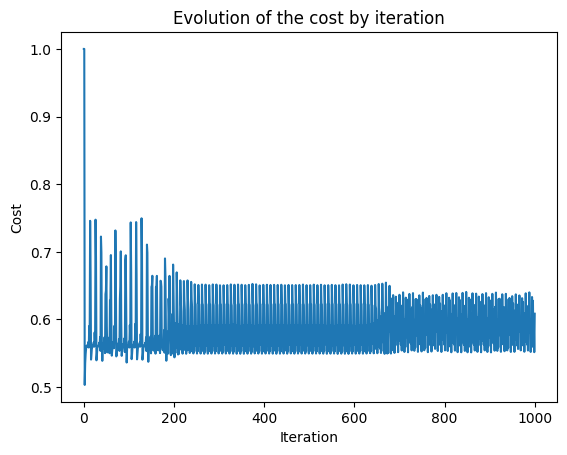

In [ ]:
# Testing the model function by training a classifier

l = 0
alpha = 0.1
epoch = 1000
batch_size = 6400

model_0 = LogRegModel(X_train_n, Y_train, X_test_n, Y_test, alpha, epoch, batch_size, l)
print('Training completed!')

print(model_0['confusion_matrix'])
print(f"Train accuracy: {model_0['train_accuracy'] * 100} %, Test accuracy: {model_0['test_accuracy'] * 100} %")

# Viewing the cost evolution over time of the trained model

cost_values = model_0['cost_history']
plt.plot(list(range(len(cost_values))),cost_values)
plt.title('Evolution of the cost by iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost');

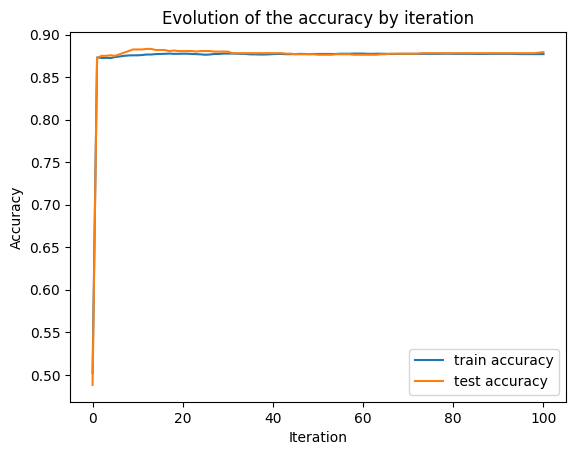

In [ ]:
+
train_values = model_0['train_history']
test_values = model_0['test_history']
plt.plot(list(range(len(train_values))),train_values)
plt.plot(list(range(len(test_values))), test_values)
plt.title('Evolution of the accuracy by iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(['train accuracy', 'test accuracy'])

In [ ]:
for i in range(2):
    print(i)

0
1


In [ ]:

++